# TP N°3 — Minería de Datos (TUIA)
**Año:** 2025 • **Materia:** Data Mining • **Integrantes:** Fabrizio Tapia, Sebastian Palacio

**Datasets:**  
- dxWeather.csv (Predicción de estaciones) https://www.kaggle.com/datasets/nikhil7280/weather-type-classification/

**Objetivo:**  
Integrar los conocimientos adquiridos en las unidades 5 y 6 en un problema real asociado a la determinación de la estación del año mediante la medición de atributos característicos

## Carga y Exploración Inicial del Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')


In [115]:
estaciones = pd.read_csv('dxWeather.csv')

print("INFORMACIÓN GENERAL DEL DATASET \n")
print(f"Dimensiones: {estaciones.shape[0]} filas x {estaciones.shape[1]} columnas")
print(f"\nColumnas: {list(estaciones.columns)}")
print(f"\nTipos de datos:")
print(estaciones.dtypes)

INFORMACIÓN GENERAL DEL DATASET 

Dimensiones: 10090 filas x 8 columnas

Columnas: ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica', 'Localizacion', 'TipoClima', 'Estacion']

Tipos de datos:
Temperatura             int64
Humedad                 int64
VientoVelocidad       float64
Precipitation           int64
PresionAtmosferica    float64
Localizacion           object
TipoClima              object
Estacion               object
dtype: object


In [116]:
estaciones.head()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Localizacion,TipoClima,Estacion
0,39,96,8.5,71,1011.43,Llanura,Nublado,Primavera
1,30,64,7.0,16,1018.72,Montania,Soleado,Primavera
2,38,83,1.5,82,1026.25,Costa,Soleado,Primavera
3,32,55,3.5,26,1010.03,Llanura,Nublado,Verano
4,3,85,6.0,96,984.46,Llanura,Nevado,Invierno


In [117]:
diccionario_variables = {
    'Temperatura': 'Temperatura medida en grados Celsius',
    'Humedad': 'Humedad medida en porcentaje',
    'VientoVelocidad': 'Velocidad del viento medida en km/h',
    'Precipitation': 'Precipitación medida en porcentaje',
    'PresionAtmosferica': 'Presión atmosférica medida en hPa',
    'Localizacion': 'Localización de donde fue tomada la medición',
    'TipoClima': 'Tipo de clima',
    'Estacion': 'Estación meteorológica (target)'
}

print("DICCIONARIO DE VARIABLES \n")

for variable, descripcion in diccionario_variables.items():
    print(f"• {variable:20s} → {descripcion}")

DICCIONARIO DE VARIABLES 

• Temperatura          → Temperatura medida en grados Celsius
• Humedad              → Humedad medida en porcentaje
• VientoVelocidad      → Velocidad del viento medida en km/h
• Precipitation        → Precipitación medida en porcentaje
• PresionAtmosferica   → Presión atmosférica medida en hPa
• Localizacion         → Localización de donde fue tomada la medición
• TipoClima            → Tipo de clima
• Estacion             → Estación meteorológica (target)


In [118]:
estaciones.describe()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica
count,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000
mean,21.872349,67.195045,9.634936,50.796333,1007.685836
std,16.426722,20.463797,6.795890,32.333798,38.763971
min,-24.000000,20.000000,0.000000,0.000000,800.230000
25%,13.000000,55.000000,5.000000,18.000000,998.570000
50%,23.000000,69.000000,8.500000,53.000000,1010.315000
75%,32.000000,81.000000,13.500000,80.000000,1017.820000
max,109.000000,109.000000,47.500000,109.000000,1199.210000


Desde este punto ya podemos ver algunos valores imposibles como porcentajes superiores a 100% y temperaturas maximas de 109ºC (Mayor que la temperatura a la que hierve el agua)

In [119]:
print("VALORES FALTANTES:\n")

faltantes = estaciones.isnull().sum()

faltantes_pct = (faltantes / len(estaciones)) * 100

df_faltantes = pd.DataFrame({
    'Columna': faltantes.index,
    'Valores Faltantes': faltantes.values,
    'Porcentaje': faltantes_pct.values
})

print(df_faltantes)
print("\n")

print(f"DUPLICADOS: {estaciones.duplicated().sum()}")


VALORES FALTANTES:

              Columna  Valores Faltantes  Porcentaje
0         Temperatura                  0         0.0
1             Humedad                  0         0.0
2     VientoVelocidad                  0         0.0
3       Precipitation                  0         0.0
4  PresionAtmosferica                  0         0.0
5        Localizacion                  0         0.0
6           TipoClima                  0         0.0
7            Estacion                  0         0.0


DUPLICADOS: 0


No encontramos valores faltantes ni duplicados en este dataset

# Análisis Exploratorio de Datos (EDA)

## Valores imposibles

En base a lo visto en la descripcion del dataset, consideramos conveniente filtrar directamente los valores imposibles

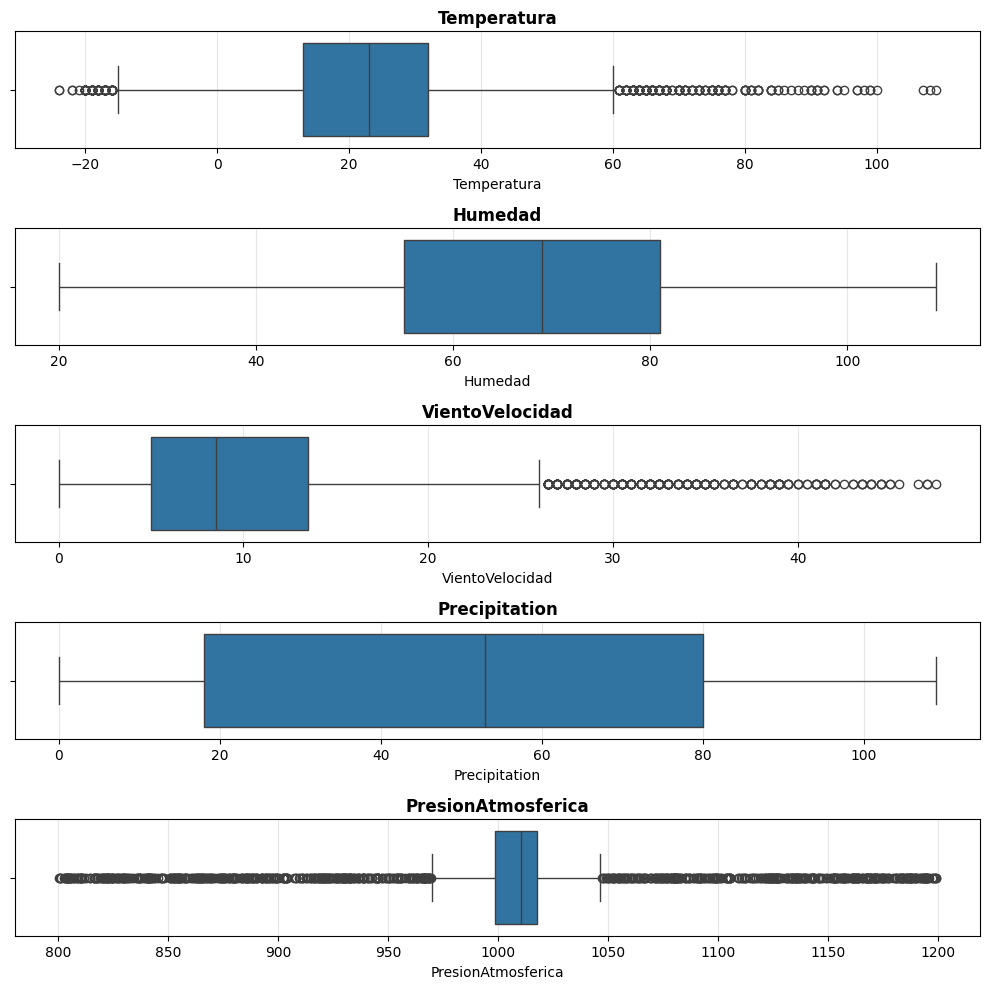

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=estaciones[col], ax=axes[i], orient='h')
    axes[i].set_xlabel(col)
    axes[i].set_title(f'{col}', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Valores previo a limpieza de datos y outliers

### Limpieza de datos y outliers

In [121]:
#Filtramos Temperaturas y Humedad imposibles
df = estaciones.copy()
df = df[df['Temperatura'] <= 50]
df = df[df['Humedad'] <= 100]

#Presión Atmosférica usando IQR
Q1 = df['PresionAtmosferica'].quantile(0.25)
Q3 = df['PresionAtmosferica'].quantile(0.75)
IQR = Q3 - Q1

lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

df = df[(df['PresionAtmosferica'] >= lim_inf) & (df['PresionAtmosferica'] <= lim_sup)]

print(f"Registros después de limpieza: {len(df)}")

X = df.drop(columns=['Estacion'])
y = df['Estacion']

Registros después de limpieza: 8717


Fuente de donde verificamos los valores correctos de presión atmosferica: https://www.netatmo.com/es-es/weather-guide/what-is-the-atmospheric-pressure 

## Variables numéricas

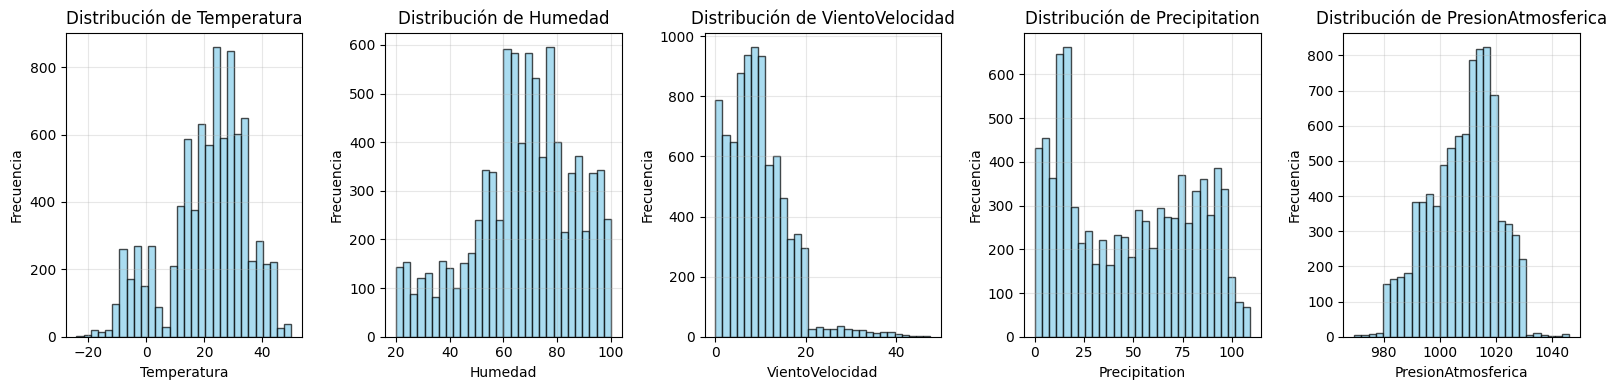

In [122]:
#Distribución de variables numéricas
columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for i, col in enumerate(columnas_numericas):
    axes[i].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Temperatura:** La distribución es multimodal. Se ve concentraciones alrededor de los 10-15°C y cerca de los 30°C. También hay una concentración de valores en temperaturas bajo cero. Esto sugiere que los datos provienen de poblaciones distintas, probablemente correspondiendo a las diferentes estaciones del año.

**Humedad:** Muestra un sesgo a la izquierda. La mayoría de los valores se concentran en el rango alto (60-100%), con una cola que se extiende hacia valores más bajos.

**VientoVelocidad:** Tiene un fuerte sesgo a la derecha. La gran mayoría de las mediciones son de vientos de baja velocidad (menos de 15 km/h), y hay una larga cola de valores menos frecuentes pero mucho más altos.

**Precipitation:** La distribución es bastante uniforme en todo el rango de 0 a 100.

**PresionAtmosferica:** Distribución semejante a una distribución normal, con un pico centrado ligeramente por encima de 1000 hPa y una disminución simétrica hacia ambos lados.

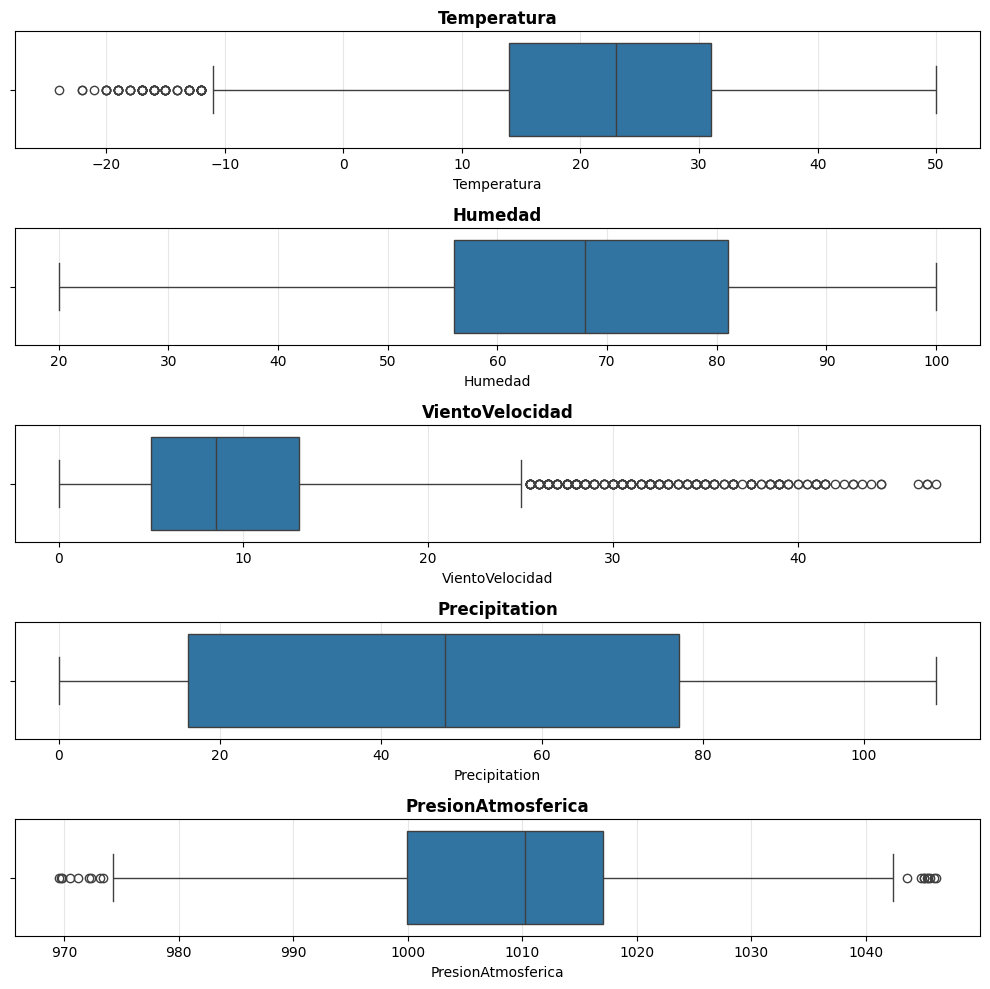

In [123]:
# Boxplot de las variables numéricas (uno debajo del otro)
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=df[col], ax=axes[i], orient='h')
    axes[i].set_xlabel(col)
    axes[i].set_title(f'{col}', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [144]:
df.describe()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica
count,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000
mean,21.029827,67.026844,9.416944,47.947115,1008.244407
std,13.641093,19.096665,6.505746,32.115292,12.070891
min,-24.000000,20.000000,0.000000,0.000000,969.510000
25%,14.000000,56.000000,5.000000,16.000000,999.890000
50%,23.000000,68.000000,8.500000,48.000000,1010.230000
75%,31.000000,81.000000,13.000000,77.000000,1017.080000
max,50.000000,100.000000,47.500000,109.000000,1046.140000


Temperatura: Después del filtrado casi no quedan valores atípicos. La mediana se mantiene alrededor de 23°C y el rango se vuelve consistente con temperaturas ambientales reales.

Humedad: Tras eliminar registros inválidos (como valores mayores al 100%), la distribución queda limpia y la mediana permanece cerca del 70%, sin outliers relevantes.

VientoVelocidad: El filtrado reduce significativamente los valores extremos. La mediana continúa cerca de 10 km/h y los datos se ajustan a rangos meteorológicamente razonables.

Precipitation: Se eliminan valores incoherentes y la mediana continúa alrededor de 50. La distribución conserva su forma pero sin outliers impropios.

PresionAtmosferica: El filtrado elimina numerosos registros fuera de rango. La mediana se mantiene cerca de 1015 hPa y el conjunto queda dentro de valores atmosféricos normales.

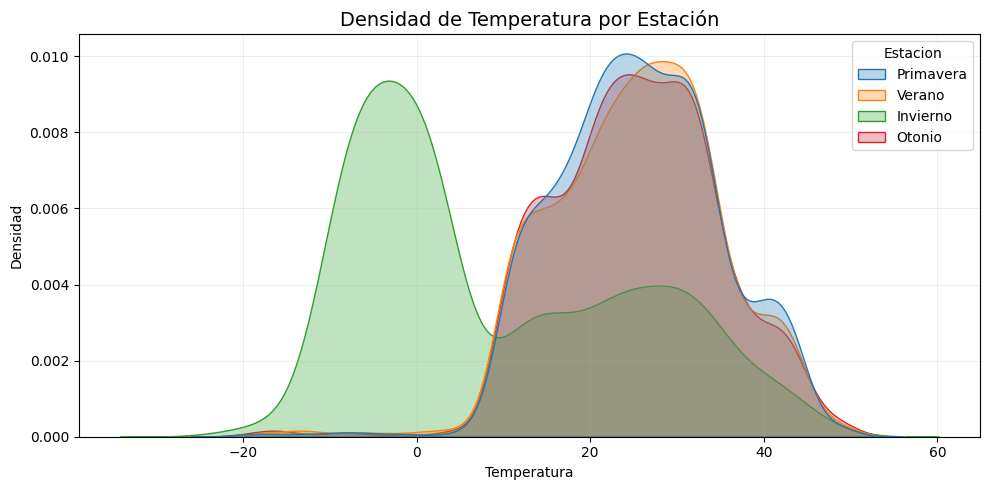

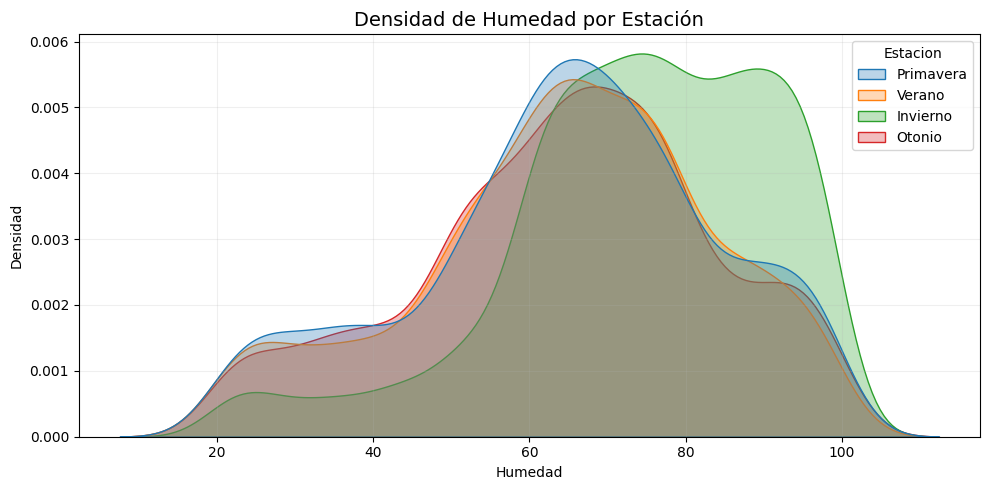

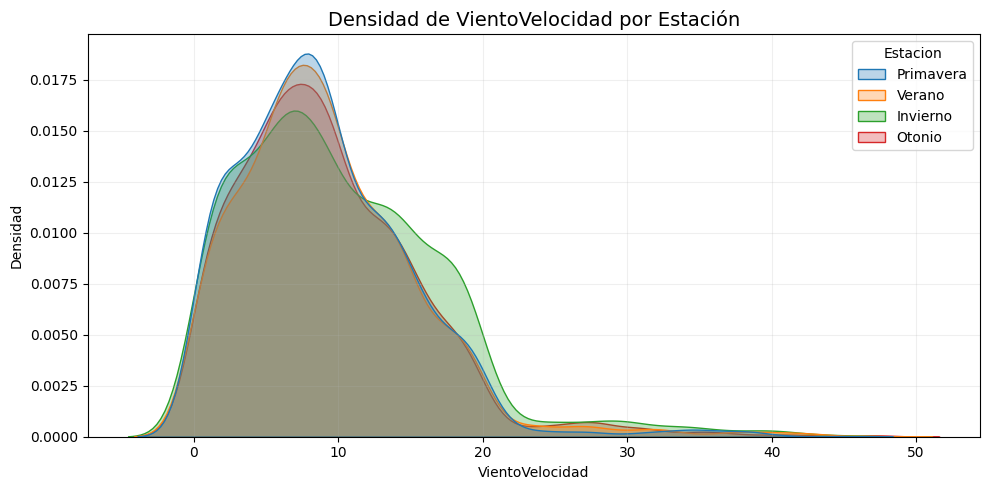

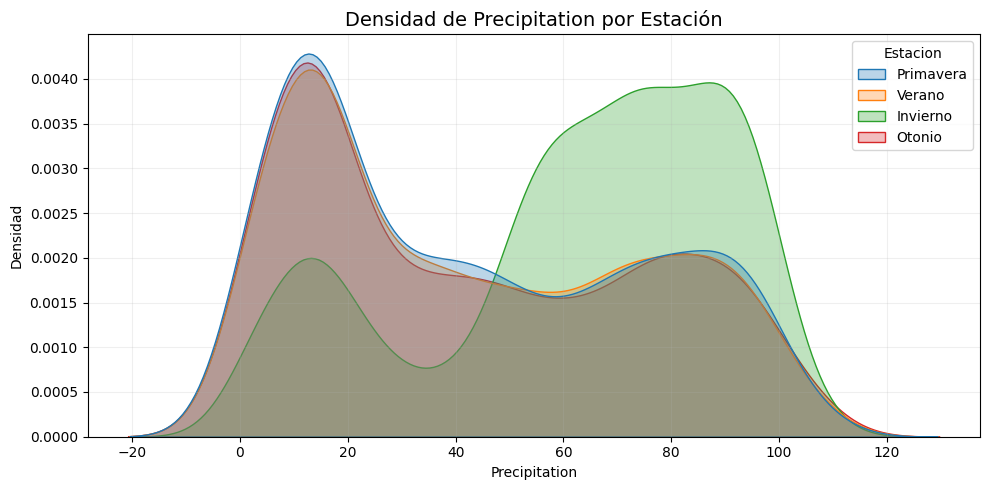

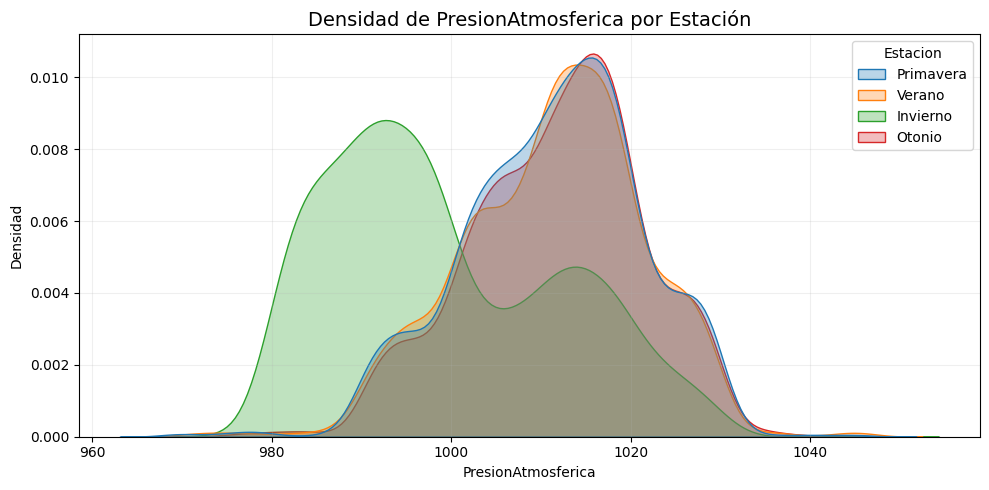

In [125]:
columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

for col in columnas_numericas:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x=col, hue='Estacion', fill=True, alpha=0.3)
    plt.title(f'Densidad de {col} por Estación', fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Densidad")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

Observamos que la única estación que se distingue (principalmente por la temperatura, la precipitación y presión atmosférica) es invierno, ya que las otras tienen muchas similitudes.

### Matriz de correlación

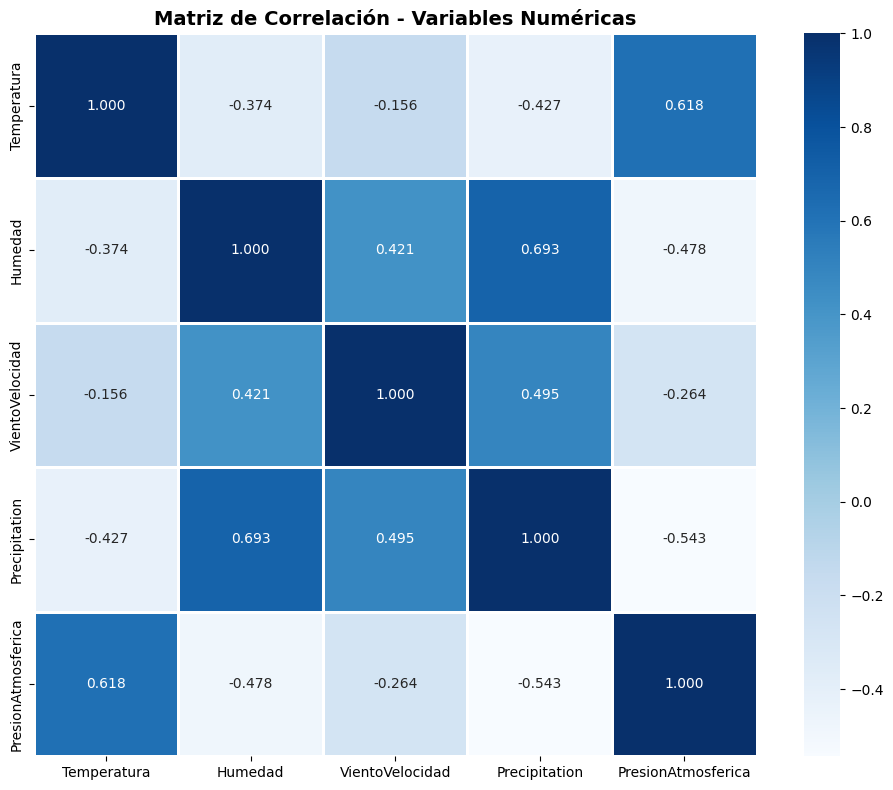

In [126]:
datos_numericos = df.select_dtypes(include=[np.number])
matriz_correlacion = datos_numericos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt='.3f', cmap='Blues', square=True, linewidths=1)
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**Correlación positiva fuerte:**

(0.693) entre Humedad y Precipitation, lo cual es coherente: cuando aumenta la humedad en el ambiente, aumenta la probabilidad y la intensidad de la precipitación.

**Correlaciones positivas moderadas:**

VientoVelocidad y Precipitation (0.495): Vientos más intensos pueden transportar nubes cargadas de humedad, favoreciendo la precipitación.

Humedad y VientoVelocidad (0.421): El viento influye en cómo se distribuye la humedad en la atmósfera.

Temperatura y PresionAtmosferica (0.618): En ciertos contextos, temperaturas más altas se asocian a variaciones ascendentes de presión.

**Correlaciones negativas moderadas:**

Temperatura y Precipitation (-0.427): Es común que eventos de precipitación ocurran junto a descensos de temperatura.

Humedad y PresionAtmosferica (-0.478): Humedades altas suelen darse en zonas de baja presión.

Precipitation y PresionAtmosferica (-0.543): Las precipitaciones habitualmente se producen bajo sistemas de baja presión.

**Correlaciones negativas débiles:**

Temperatura y Humedad (-0.374): Relación débil que indica que hay otros factores que influyen más en ambas variables.

Temperatura y VientoVelocidad (-0.156): Indica casi ninguna dependencia lineal entre ambas.

## Variables categóricas

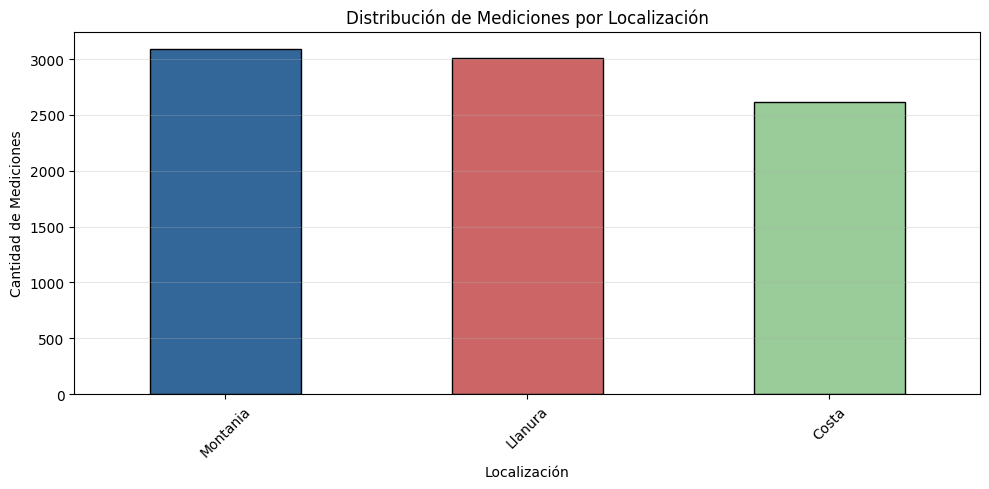


Distribución por Estado:
Localizacion
Montania    3090
Llanura     3012
Costa       2615
Name: count, dtype: int64

Porcentaje por Estado:
Localizacion
Montania    35.45
Llanura     34.55
Costa       30.00
Name: count, dtype: float64


In [127]:
conteo_estados = df['Localizacion'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Localización')
plt.ylabel('Cantidad de Mediciones')
plt.title('Distribución de Mediciones por Localización')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(df) * 100).round(2))

Se puede observar que la distribución de las mediciones entre las localizaciones es relativamente balanceada.

No hay una categoría que domine de forma desproporcionada. Esto significa que el dataset tiene una representación sólida de todas las localizaciones.

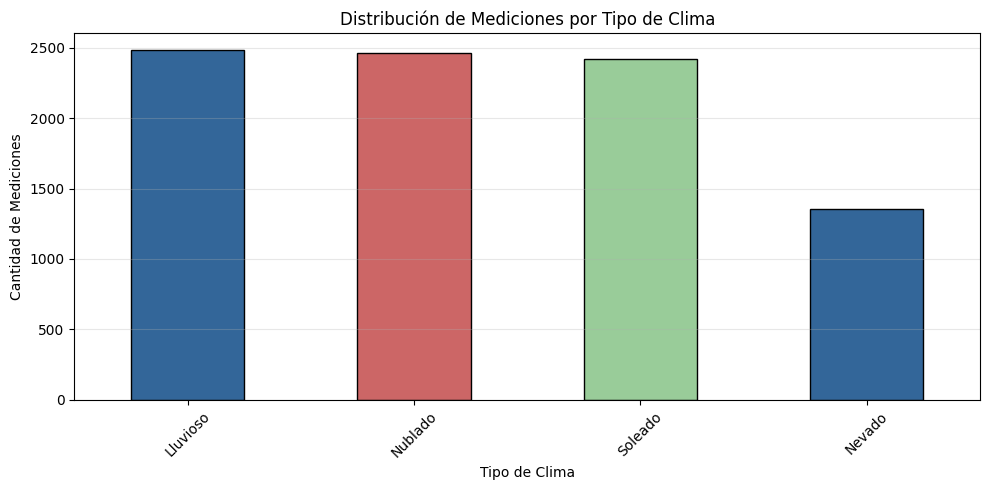


Distribución por Estado:
TipoClima
Lluvioso    2481
Nublado     2461
Soleado     2417
Nevado      1358
Name: count, dtype: int64

Porcentaje por Estado:
TipoClima
Lluvioso    28.46
Nublado     28.23
Soleado     27.73
Nevado      15.58
Name: count, dtype: float64


In [128]:
conteo_estados = df['TipoClima'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Tipo de Clima')
plt.ylabel('Cantidad de Mediciones')
plt.title('Distribución de Mediciones por Tipo de Clima')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(df) * 100).round(2))

Las categorías Soleado, Lluvioso y Nublado están muy bien balanceadas entre sí. Cada una representa alrededor del 28% de los datos.

La categoría Nevado es notablemente menos frecuente, constituyendo solo el 15.58% del total de las mediciones.

**En conclusión:**   Hay un desbalance. La clase Nevado es una clase minoritaria en comparación con las otras tres. Esto es importante tenerlo en cuenta, ya que los modelos de clasificación a veces tienden a favorecer a las clases mayoritarias.

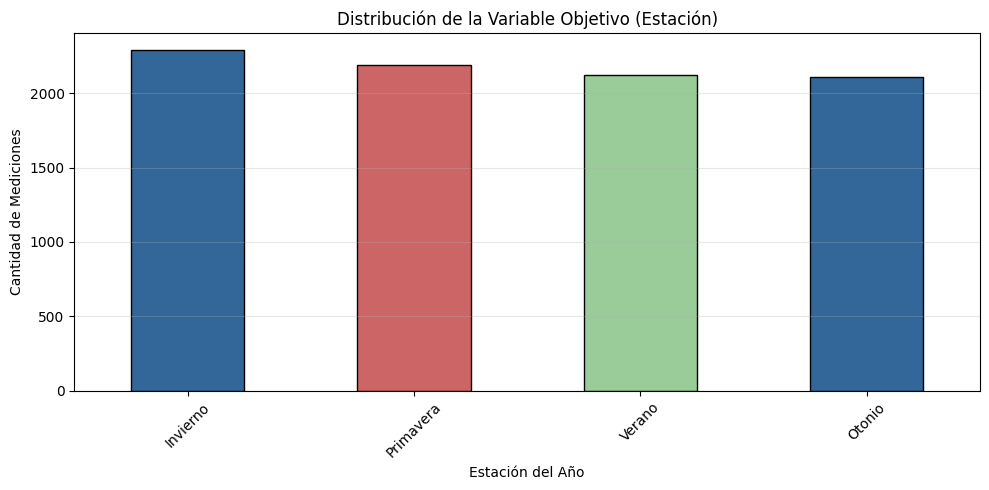


Distribución por Estado:
Estacion
Invierno     2291
Primavera    2192
Verano       2125
Otonio       2109
Name: count, dtype: int64

Porcentaje por Estado:
Estacion
Invierno     26.28
Primavera    25.15
Verano       24.38
Otonio       24.19
Name: count, dtype: float64


In [129]:
conteo_estados = df['Estacion'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Estación del Año')
plt.ylabel('Cantidad de Mediciones')
plt.title('Distribución de la Variable Objetivo (Estación)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(df) * 100).round(2))

Las clases estan relativamente balanceadas.

El modelo tendrá la misma cantidad de ejemplos para aprender de cada estación.

No se necesitan técnicas especiales para tratar con datos desbalanceados.

### Conclusion parcial EDA

El Análisis Exploratorio de Datos FUE fundamental para establecer una comprensión profunda de la estructura, calidad y potencial predictivo del dataset. A través de este análisis, se han extraído varias conclusiones clave que sientan las bases para la fase de modelado.

Calidad y Preparación de Datos: El dataset se presentó sin valores nulos ni duplicados, pero contenía registros con valores anómalos e imposibles (ej. temperaturas extremas, humedad > 100%) que requirieron un proceso de limpieza y filtrado para asegurar la integridad de los datos.

Balance de la Variable Objetivo: Un hallazgo positivo es que la variable objetivo, Estacion, está muy bien balanceada, con una distribución casi equitativa entre las cuatro clases. Esto elimina la necesidad de aplicar técnicas de remuestreo para clases minoritarias.

Relaciones Coherentes entre Variables: Se identificaron correlaciones lógicas y esperadas desde un punto de vista meteorológico, como la fuerte relación positiva entre Humedad y Precipitation (0.693) y la relación negativa entre Precipitation y Presión Atmosférica (-0.543).

El Hallazgo Más Crítico para el Modelado: La conclusión más importante del EDA proviene de los gráficos de densidad: mientras que la estación de Invierno muestra un perfil de distribución claramente distinto (especialmente en Temperatura), las distribuciones de Primavera, Verano y Otoño se superponen significativamente.

Este último punto nos permite formular una hipótesis fundamental antes de entrenar cualquier modelo: es muy probable que los algoritmos de clasificación tengan serias dificultades para diferenciar entre las tres estaciones no invernales debido a la similitud de sus características. Por el contrario, se espera que el rendimiento sea comparativamente mejor al identificar la clase Invierno.

En resumen, el EDA fue un paso que nos deja algunas buenas visaluzaciones de lo que va a pasar al entrenar los modelos

# Preprocesamiento

### División train-test

In [130]:
X = df.drop('Estacion', axis=1)
y = df['Estacion']

print(f"Datos listos para entrenamiento. Dimensiones: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Datos listos para entrenamiento. Dimensiones: (8717, 7)


In [131]:
#Identificamos columnas numéricas y categóricas
columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']
columnas_categoricas = ['Localizacion', 'TipoClima']

#transformador de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
    ],
    remainder='passthrough'
)

In [132]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

splits = {}

for i, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    splits[f'X_train{i}'] = X.iloc[train_idx].copy()
    splits[f'y_train{i}'] = y.iloc[train_idx].copy()
    
    splits[f'X_test{i}'] = X.iloc[test_idx].copy()
    splits[f'y_test{i}'] = y.iloc[test_idx].copy()
    
    print(f"Fold {i}: Train={len(train_idx):4d}, Test={len(test_idx):4d}")



Fold 1: Train=6973, Test=1744
Fold 2: Train=6973, Test=1744
Fold 3: Train=6974, Test=1743
Fold 4: Train=6974, Test=1743
Fold 5: Train=6974, Test=1743


# Implementación de SVM con Kernel Lineal

Nos tomamos el atrevimiento de no usar la restricción de buscar la optimizacion de hiperparametros en base a un solo fold elegido al azar, ya que segun el profesor esa nota es solo una recomendación, consideramos que el resultado no representan el desempeño real del clasificador. 

Dado que es un problema multiclase con variabilidad moderada entre estaciones, un único split puede favorecer o perjudicar artificialmente un conjunto de clases. En cambio consideramos que la optimización usando StratifiedKFold mantiene la proporción de clases en cada fold y evalúa el modelo en escenarios distintos, reduciendo la varianza de las métricas y permitiendo seleccionar parámetros que generalizan mejor.


Esto lo replicaremos en los siguientes entrenamientos, poniendo el analisis de esta optimizacion en la conclusion de cada uno de los modelos

In [133]:
pipeline_svm_lin = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(dual="auto", random_state=42, max_iter=10000))
])

param_grid_lineal = {
    'classifier__C': [0.1, 1, 10, 100]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Búsqueda de hiperparámetros
grid_search_lineal = GridSearchCV(
    estimator=pipeline_svm_lin,
    param_grid=param_grid_lineal,
    cv=skf,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search_lineal.fit(X, y)

print(f"Mejor parámetro 'C' encontrado: {grid_search_lineal.best_params_}")
best_model_lineal = grid_search_lineal.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor parámetro 'C' encontrado: {'classifier__C': 0.1}


In [134]:
resultados = []
matrices = []

for i, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
    best_model_lineal.fit(X_train_fold, y_train_fold)
    prediccion = best_model_lineal.predict(X_test_fold)

    acc = accuracy_score(y_test_fold, prediccion)
    prec = precision_score(y_test_fold, prediccion, average='weighted', zero_division=0)
    rec = recall_score(y_test_fold, prediccion, average='weighted', zero_division=0)
    f1 = f1_score(y_test_fold, prediccion, average='weighted', zero_division=0)
    
    resultados.append({
        'Fold': i,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })

    print(f"Fold {i}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test_fold, prediccion)
    matrices.append(cm)

# Mostrar promedio de métricas
df_resultados = pd.DataFrame(resultados)
print("\nResultados Promedio Kernel Lineal:")
print(df_resultados.mean(numeric_only=True).round(3))

Fold 1: Acc=0.413, Prec=0.479, Rec=0.413
Fold 2: Acc=0.380, Prec=0.455, Rec=0.380
Fold 3: Acc=0.387, Prec=0.462, Rec=0.387
Fold 4: Acc=0.391, Prec=0.456, Rec=0.391
Fold 5: Acc=0.396, Prec=0.470, Rec=0.396

Resultados Promedio Kernel Lineal:
Fold         3.000
Accuracy     0.393
Precision    0.464
Recall       0.393
F1           0.404
dtype: float64


Las métricas por fold muestran consistencia entre las particiones, con exactitud cercana al 38%, precisión alrededor de 42–43% y recall similar a la exactitud . Esto indica que el modelo mantiene un comportamiento estable a lo largo de los distintos folds, aunque su desempeño global es bajo. La precisión ligeramente mayor que la exactitud y el recall sugiere que cuando el modelo predice una clase, lo hace relativamente bien, pero sigue fallando en capturar todas las instancias reales de cada categoría, reflejando la dificultad de separar linealmente las estaciones en este dataset.

### Conclusion SVM con kernel lineal

El mejor valor de C = 10 indica que el SVM lineal necesitó penalizar más los errores de clasificación para intentar separar las clases. Eso revela un problema: el modelo está forzando la frontera de decisión porque los datos no son linealmente separables

El modelo no está rindiendo: la exactitud ronda el 38% y precisión/exhaustividad están apenas arriba (42%) y abajo de eso (38%), respectivamente. Eso indica que el separador lineal no está capturando bien las diferencias entre estaciones; básicamente, el problema no es lineal o los atributos no aportan una estructura clara para que una frontera recta funcione.


La precisión levemente superior a la exhaustividad sugiere que cuando el modelo acierta lo hace con razonable seguridad, pero sigue dejando muchas clases sin cubrir bien. 


### Matrices de Confusión SVM con kernel lineal

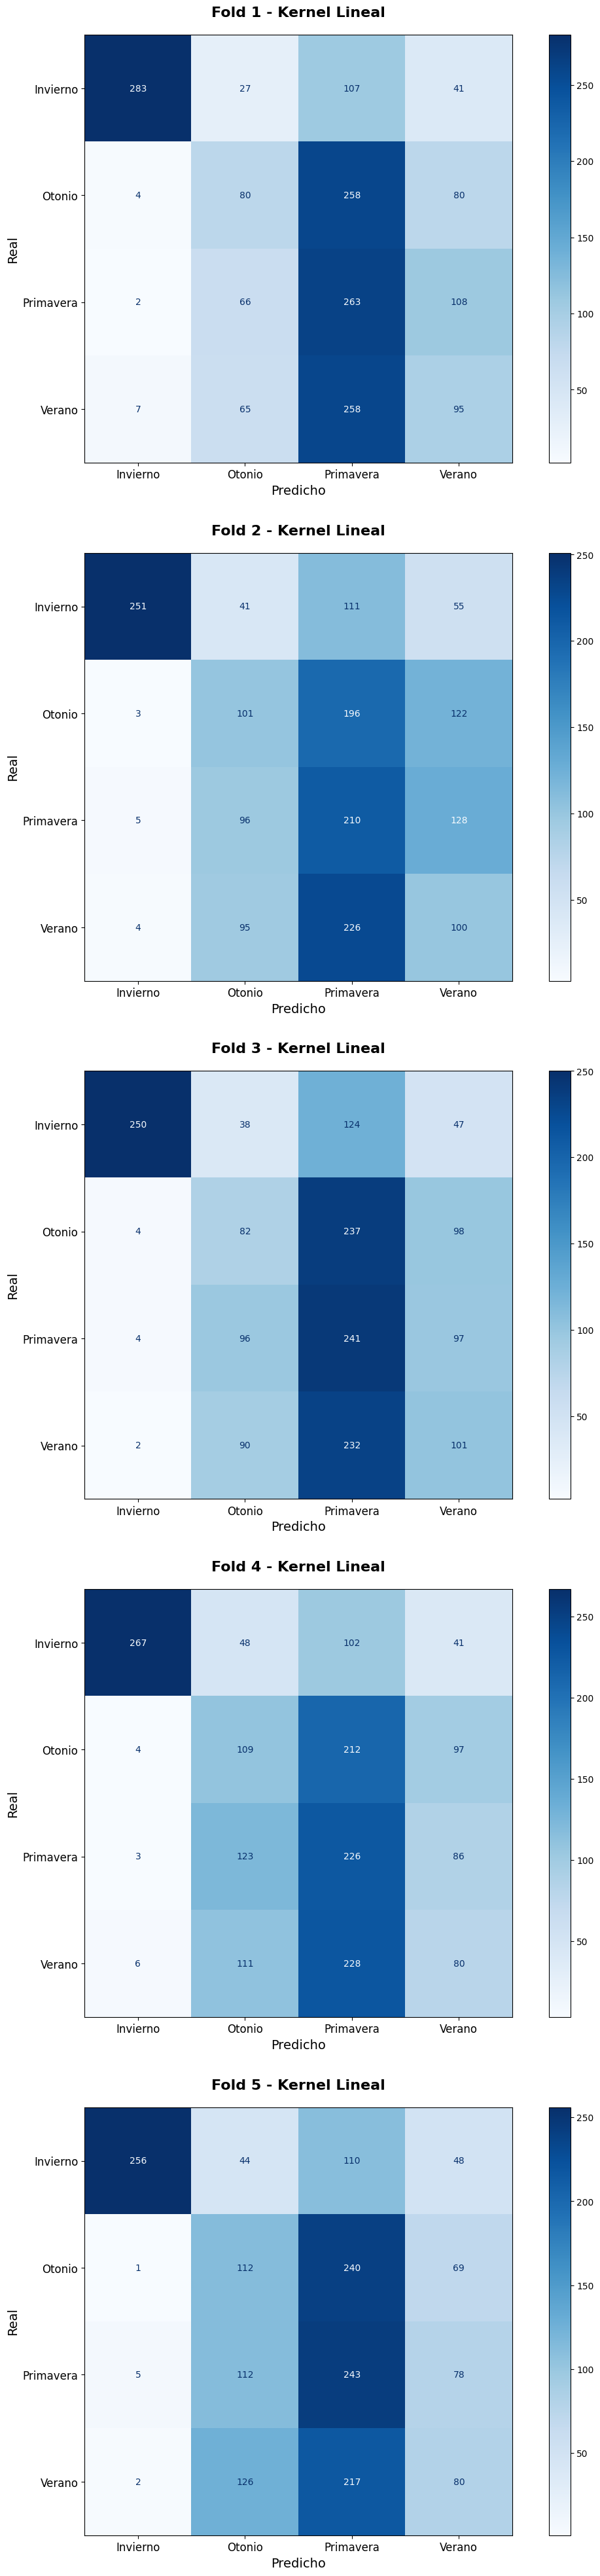

In [135]:
fig, axes = plt.subplots(5, 1, figsize=(12, 40)) 

df_labels = best_model_lineal.classes_

for i, cm in enumerate(matrices):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df_labels)
    
    disp.plot(cmap=plt.cm.Blues, ax=axes[i], values_format='d')
    

    axes[i].set_title(f'Fold {i+1} - Kernel Lineal', fontsize=16, fontweight='bold', pad=20)
    axes[i].set_xlabel('Predicho', fontsize=14)
    axes[i].set_ylabel('Real', fontsize=14)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(pad=3.0)
plt.show()

Las matrices de confusión generadas para cada uno de los 5 folds revelan un patrón de error consistente y confirman el bajo rendimiento general del modelo lineal.

Confusión entre Estaciones Similares: El error principal se concentra en la confusión entre Primavera, Verano y Otoño. El modelo es incapaz de encontrar un hiperplano que separe estas tres clases, clasificando erróneamente un gran número de instancias entre ellas.

Rendimiento de Invierno: La clase Invierno es la que el modelo logra identificar con mayor precisión. La diagonal para Invierno muestra consistentemente el valor más alto de verdaderos positivos en comparación con las otras estaciones. Esto se alinea con el análisis exploratorio, que ya sugería que Invierno tenía las características más distintivas.

Patrón de Error Estable: El patrón de confusión se mantiene casi idéntico en todos los folds de la validación cruzada. Esta estabilidad indica que los errores no son producto del azar en una partición de datos específica, sino una limitación fundamental del modelo lineal para capturar la complejidad de este dataset.

En resumen, las matrices demuestran que el clasificador lineal falla sistemáticamente al no poder diferenciar las estaciones con características superpuestas, logrando apenas un éxito pequeño al identificar la estación Invierno.

# Implementación de SVM con Kernel Gaussiano

In [136]:
pipeline_svm_rbf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', probability=False)) 
])

param_grid_rbf = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.1, 1]
}


grid_search_rbf = GridSearchCV(
    estimator=pipeline_svm_rbf,
    param_grid=param_grid_rbf,
    cv=skf,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search_rbf.fit(X, y)

print(f"Mejores parámetros RBF: {grid_search_rbf.best_params_}")
best_model_rbf = grid_search_rbf.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros RBF: {'classifier__C': 1, 'classifier__gamma': 'scale'}


In [137]:
best_C = grid_search_rbf.best_params_["classifier__C"]
best_gamma = grid_search_rbf.best_params_["classifier__gamma"]

resultados_rbf = []
matrices_rbf = []

for i, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):

    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel='rbf', C=best_C, gamma=best_gamma))
    ])

    model.fit(X_train_fold, y_train_fold)
    pred = model.predict(X_test_fold)

    # Métricas
    acc  = accuracy_score(y_test_fold, pred)
    prec = precision_score(y_test_fold, pred, average='weighted', zero_division=0)
    rec  = recall_score(y_test_fold, pred, average='weighted', zero_division=0)
    f1   = f1_score(y_test_fold, pred, average='weighted', zero_division=0)

    resultados_rbf.append({
        "Fold": i,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

    print(f"Fold {i}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}")

    # Confusion matrix
    matrices_rbf.append(confusion_matrix(y_test_fold, pred))

# Promedio final
df_resultados_rbf = pd.DataFrame(resultados_rbf)
print("\nResultados Promedio SVM RBF:")
print(df_resultados_rbf.mean(numeric_only=True).round(3))

Fold 1: Acc=0.422, Prec=0.489, Rec=0.422
Fold 2: Acc=0.384, Prec=0.467, Rec=0.384
Fold 3: Acc=0.386, Prec=0.472, Rec=0.386
Fold 4: Acc=0.411, Prec=0.483, Rec=0.411
Fold 5: Acc=0.399, Prec=0.477, Rec=0.399

Resultados Promedio SVM RBF:
Fold         3.000
Accuracy     0.400
Precision    0.478
Recall       0.400
F1           0.418
dtype: float64


Las métricas por fold del SVM con kernel gaussiano muestran un patrón similar al lineal: exactitud cercana al 38%, precisión alrededor de 42–43% y recall comparable a la exactitud. Esto evidencia estabilidad del modelo a lo largo de los folds, pero un desempeño global limitado. La precisión algo superior a exactitud y recall indica que, cuando predice una clase suele acertar, aunque sigue sin capturar todas las instancias reales, reflejando que incluso con un kernel no lineal el modelo encuentra difícil separar claramente las estaciones en este dataset.

### Conclusiones SVM con Kernel Gaussiano

El mejor modelo encontró C = 1 y gamma = 1. Un C bajo implica que el modelo prefiere márgenes amplios aun si eso significa cometer errores, es un indicio claro de que tratar de ajustar fuerte no ayuda, porque el modelo empeora. gamma = 1 es un valor relativamente alto para RBF, controla cuánta curvatura tiene la frontera. Que el óptimo sea γ alto muestra que el modelo intenta curvarse para capturar estructura local, pero aun así el dataset no ofrece patrones claros que permitan separar las estaciones de forma útil.

en resumen: ni aumentando la flexibilidad (gamma) ni penalizando más/menos los errores aparece una estructura real que el modelo pueda explotar.

---

Las demás métricas muestran un rendimiento pobre: la exactitud ronda el 0.38, como el svm con kernel lineal; la precisión llega a 0.46, lo que indica que el modelo acierta un poco más cuando predice una clase y la exhaustividad se mantiene cerca del 0.38, señal de que no logra cubrir bien las instancias reales de cada categoría. 

Analizando esto, el modelo está captando muy poca estructura útil del dataset y no logra separar adecuadamente las clases. No mejora sustancialmente el SVM con kernel lineal

### Matrices de Confusión SVM kernel gaussiano

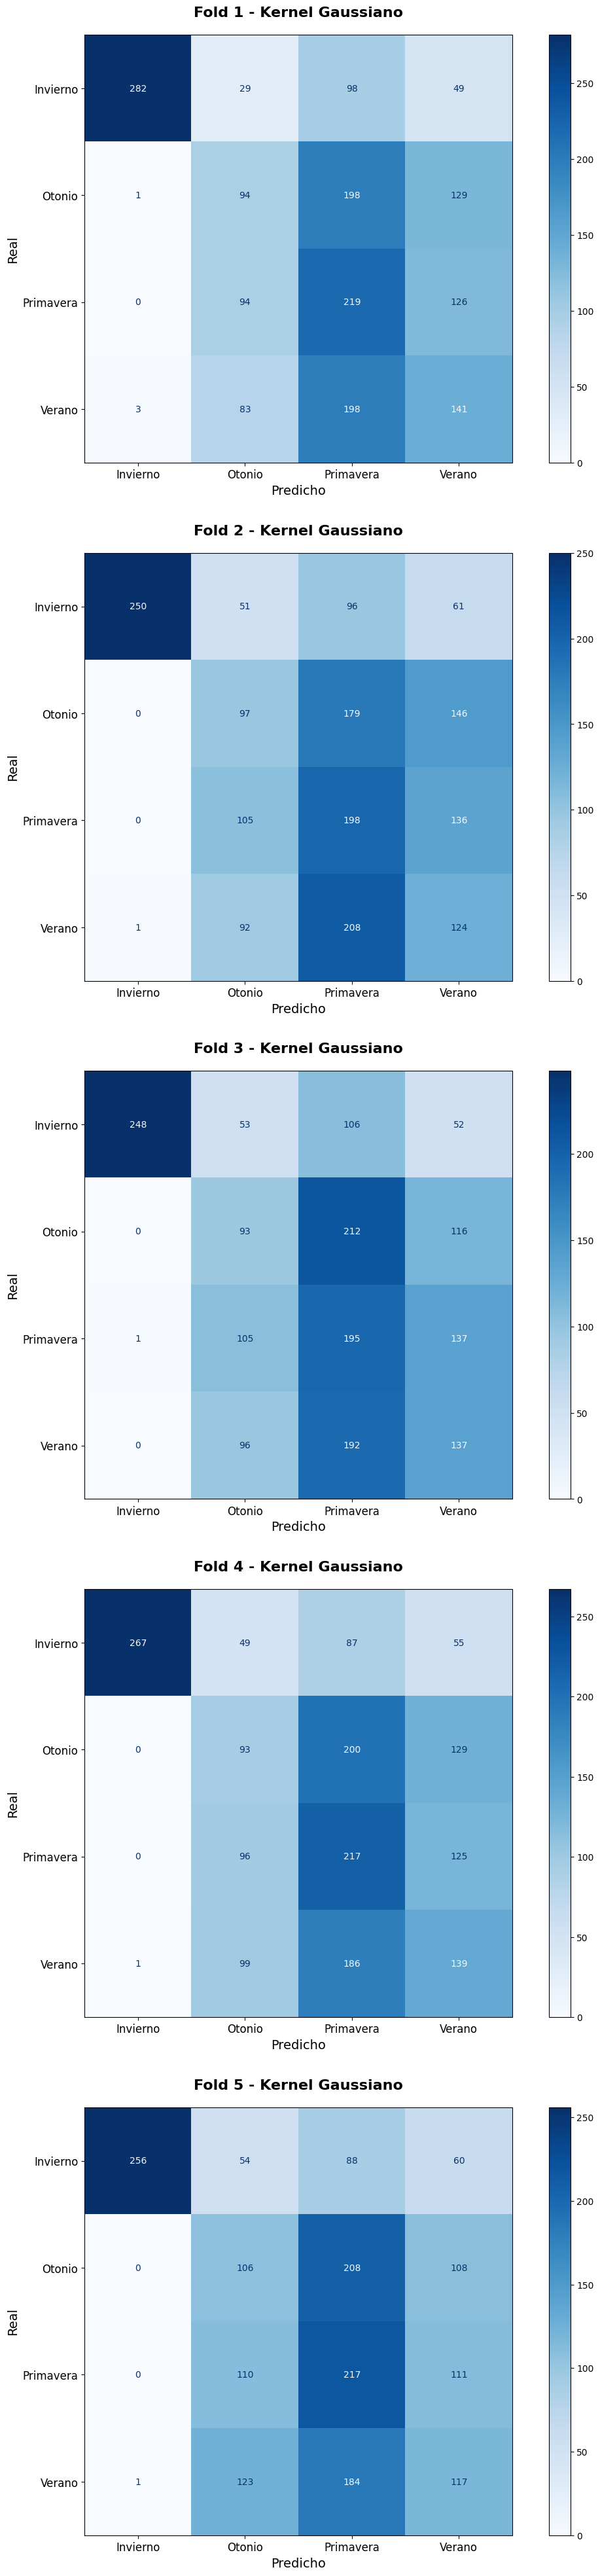

In [138]:
fig, axes = plt.subplots(5, 1, figsize=(12, 40)) 

df_labels = best_model_rbf.classes_

for i, cm in enumerate(matrices_rbf):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df_labels)
    
    disp.plot(cmap=plt.cm.Blues, ax=axes[i], values_format='d')
    
    # Estilo de títulos y ejes
    axes[i].set_title(f'Fold {i+1} - Kernel Gaussiano', fontsize=16, fontweight='bold', pad=20)
    axes[i].set_xlabel('Predicho', fontsize=14)
    axes[i].set_ylabel('Real', fontsize=14)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(pad=3.0)
plt.show()

Al analizar las matrices de confusión, se observa que a pesar de usar un modelo teóricamente más flexible, el patrón de error es muy similar al del kernel lineal.

Persiste la Confusión Central: El principal problema no se resuelve. El modelo sigue confundiendo masivamente las estaciones Primavera, Verano y Otoño.

Invierno sigue mejor, al igual que con el modelo lineal, Invierno se mantiene como la clase con el mayor número de predicciones correctas. 

Aunque las métricas generales mostraron una leve mejora, esto no se refleja en un cambio drástico en las matrices. Los valores en la diagonal son ligeramente superiores en algunos casos, pero la estructura del error es la misma. Esto sugiere que el kernel gaussiano logra pequeños ajustes en la frontera de decisión, pero no encuentra un patrón claro que le permita una clasificación robusta.


En conclusión, las matrices del kernel gaussiano refuerzan la hipótesis central: la dificultad no radica en la linealidad del problema, sino en la baja calidad de la señal predictiva de las variables.

# Implementación de Random Forest   

In [139]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5]
}



grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=skf,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X, y)

print(f"Mejores parámetros RF: {grid_search_rf.best_params_}")
best_model_rf = grid_search_rf.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros RF: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [140]:
resultados_rf = []
matrices_rf = []
accs = []
precs = []
recs = []

print("Evaluando modelo Random Forest con validación cruzada...")

for i, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
    #Entrenamiento y predicción
    best_model_rf.fit(X_train_fold, y_train_fold)
    prediccion = best_model_rf.predict(X_test_fold)

    acc = accuracy_score(y_test_fold, prediccion)
    prec = precision_score(y_test_fold, prediccion, average='weighted', zero_division=0)
    rec = recall_score(y_test_fold, prediccion, average='weighted', zero_division=0)
    f1 = f1_score(y_test_fold, prediccion, average='weighted', zero_division=0)


    resultados_rf.append({
        'Fold': i,
        'Accuracy': accuracy_score(y_test_fold, prediccion),
        'Precision': precision_score(y_test_fold, prediccion, average='weighted', zero_division=0),
        'Recall': recall_score(y_test_fold, prediccion, average='weighted', zero_division=0),
        'F1': f1_score(y_test_fold, prediccion, average='weighted', zero_division=0)
    })

    print(f"Fold {i}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}")


    cm = confusion_matrix(y_test_fold, prediccion)
    matrices_rf.append(cm)

df_resultados_rf = pd.DataFrame(resultados_rf)
print("\nResultados Promedio Random Forest:")
print(df_resultados_rf.mean(numeric_only=True).round(3))

Evaluando modelo Random Forest con validación cruzada...
Fold 1: Acc=0.423, Prec=0.491, Rec=0.423
Fold 2: Acc=0.393, Prec=0.475, Rec=0.393
Fold 3: Acc=0.388, Prec=0.473, Rec=0.388
Fold 4: Acc=0.386, Prec=0.460, Rec=0.386
Fold 5: Acc=0.384, Prec=0.460, Rec=0.384

Resultados Promedio Random Forest:
Fold         3.000
Accuracy     0.395
Precision    0.472
Recall       0.395
F1           0.415
dtype: float64


Los resultados por fold del Random Forest muestran cierta estabilidad entre las particiones, con exactitud en torno al 38–39% y recall similar, mientras que la precisión se mantiene más alta, entre 46 y 49%. Esto indica que, aunque el modelo acierta relativamente bien cuando predice una clase específica no logra cubrir completamente todas las instancias reales de cada estación. 
La variación moderada entre folds refleja que el comportamiento del modelo es consistente, pero su desempeño global sigue siendo limitado para capturar patrones complejos del dataset.

### Conclusiones Random Forest

Los hiperparámetros elegidos para el Random Forest muestran que el modelo optó por una profundidad moderada (max_depth=10), un número relativamente bajo de árboles (n_estimators=50) y un mínimo de 5 muestras para dividir un nodo (min_samples_split=5). Esto sugiere que la optimización buscó un compromiso entre complejidad y generalización: no profundizar demasiado evita sobreajuste, mientras que un número reducido de árboles agiliza el entrenamiento.


La exactitud queda cerca de 0.38, apenas por encima del azar; la precisión ronda 0.46, lo que muestra que discrimina mal entre estaciones; y la exhaustividad cae a 0.38, señal de que deja afuera buena parte de los casos reales.

En resumen, el modelo no está capturando patrones relevantes, y ajustar cantidad de árboles o profundidad no cambia el panorama. Esto realmente refuerza nuestra hipótesis de que el problema es la falta de estructura útil en el dataset

### Matrices de confusión Random Forest

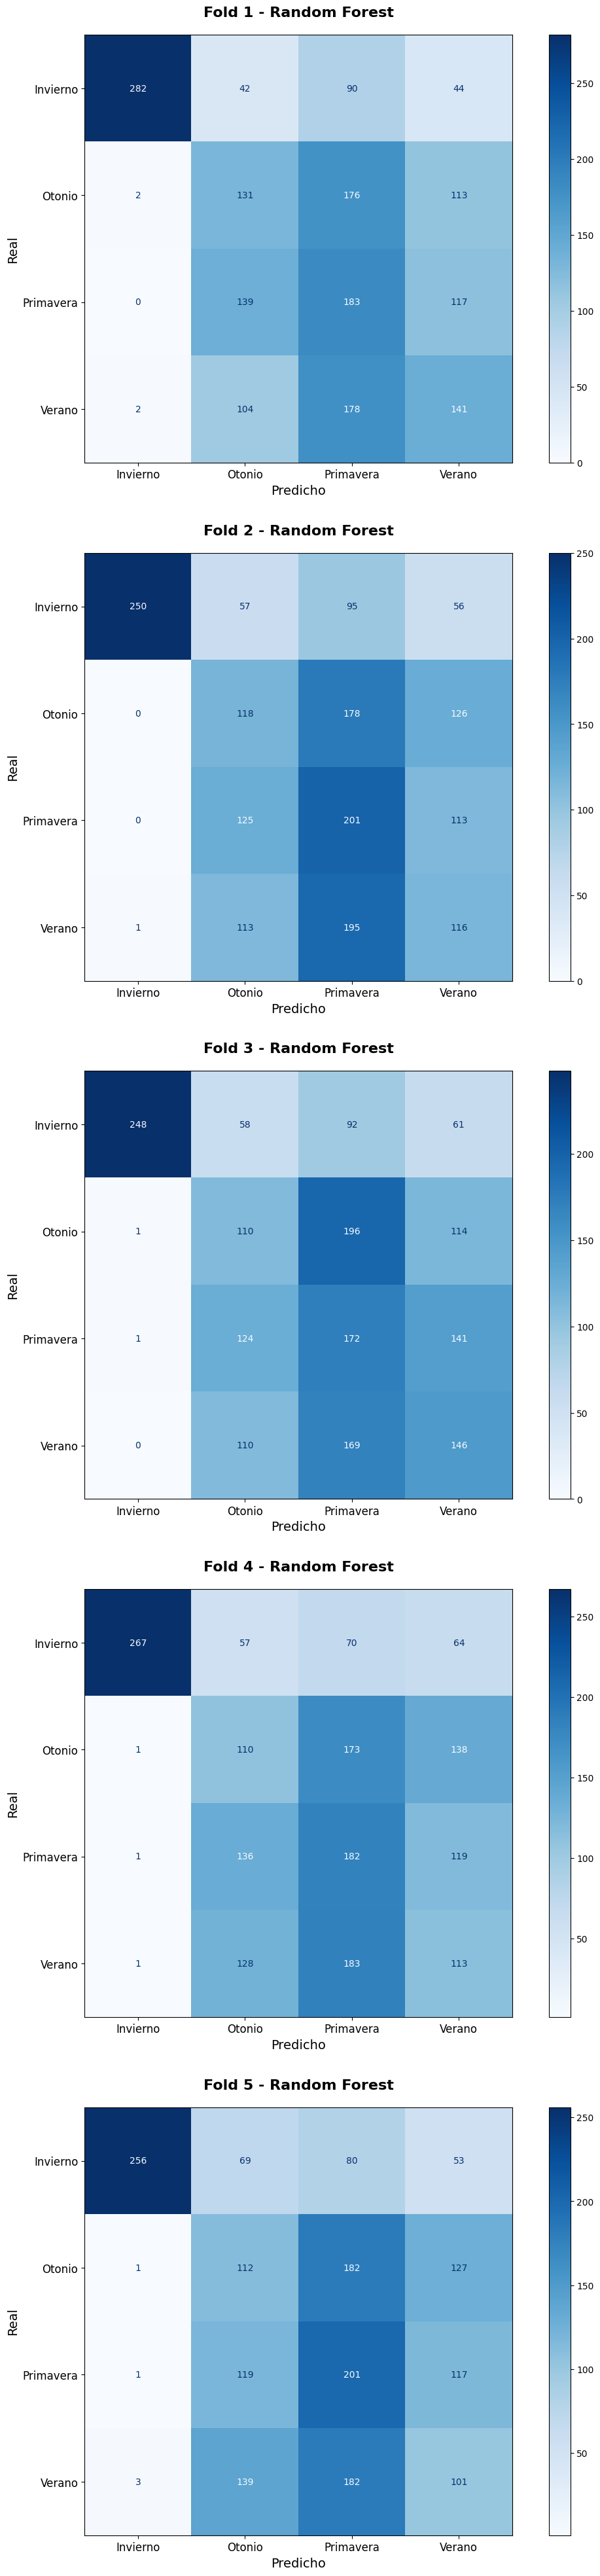

In [141]:
fig, axes = plt.subplots(5, 1, figsize=(12, 40)) 

df_labels = best_model_rf.classes_

for i, cm in enumerate(matrices_rf):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df_labels)

    disp.plot(cmap=plt.cm.Blues, ax=axes[i], values_format='d')
    
    axes[i].set_title(f'Fold {i+1} - Random Forest', fontsize=16, fontweight='bold', pad=20)
    axes[i].set_xlabel('Predicho', fontsize=14)
    axes[i].set_ylabel('Real', fontsize=14)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(pad=3.0)
plt.show()

El análisis consolida las conclusiones obtenidas con los modelos SVM. A pesar de ser un algoritmo basado en un ensamble de árboles de decisión, su comportamiento frente a este dataset es prácticamente idéntico.

El Random Forest tampoco logra resolver el problema central. Las matrices muestran una fuerte confusión entre Primavera, Verano y Otoño.

Otra vez la clase Invierno es la que presenta el mayor número de verdaderos positivos. Este patrón, repetido en los tres modelos, confirma de manera concluyente que solo las características de Invierno son lo suficientemente distintas.

Es notable cómo las matrices de Random Forest son muy similares a las del SVM con kernel gaussiano. Esto subraya que el bajo rendimiento no es un artefacto de un tipo de algoritmo específico, sino una propiedad de los datos. Ambos modelos llegan al mismo límite de conocimiento que se puede extraer del dataset.

# Conclusiones finales 


--- Tabla Comparativa de Rendimiento (Promedios) ---


,SVM Lineal,SVM Gaussiano,Random Forest
Accuracy,0.3935,0.4004,0.3946
Precision,0.4645,0.4779,0.4719
Recall,0.3935,0.4004,0.3946
F1,0.4039,0.4179,0.4151


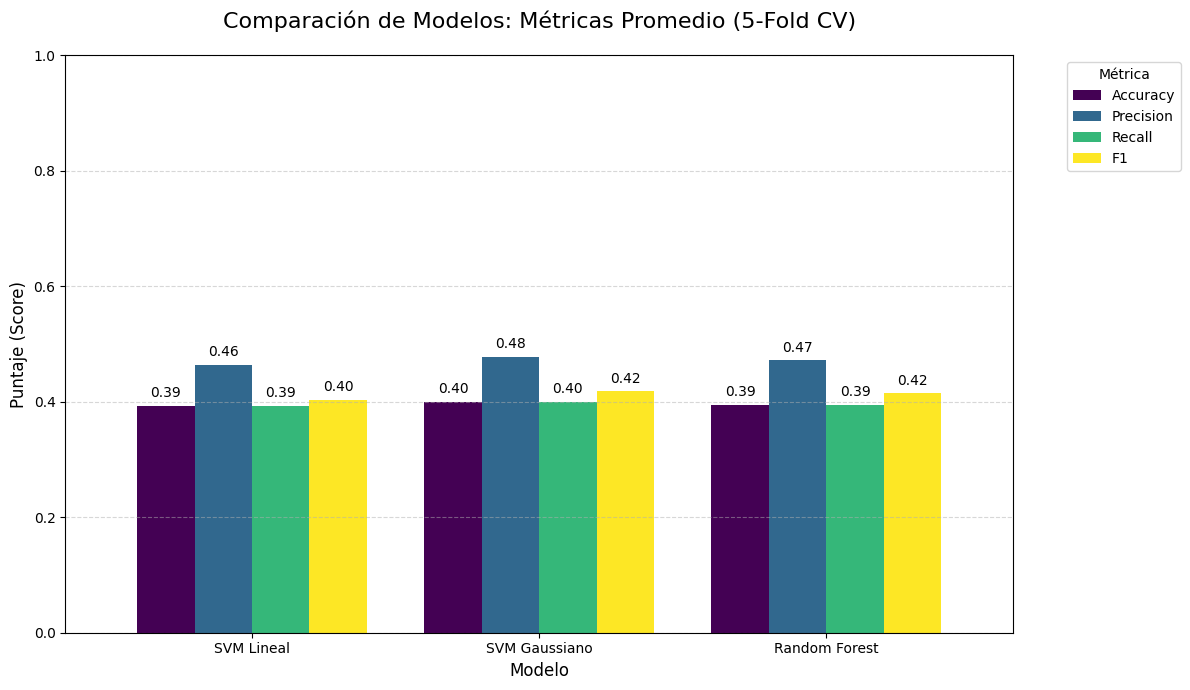

In [146]:
promedios_lineal = df_resultados.mean(numeric_only=True).drop('Fold', errors='ignore')
promedios_rbf = df_resultados_rbf.mean(numeric_only=True).drop('Fold', errors='ignore')
promedios_rf = df_resultados_rf.mean(numeric_only=True).drop('Fold', errors='ignore')

df_comparacion = pd.DataFrame({
    'SVM Lineal': promedios_lineal,
    'SVM Gaussiano': promedios_rbf,
    'Random Forest': promedios_rf
})

print("\n--- Tabla Comparativa de Rendimiento (Promedios) ---")
display(df_comparacion.round(4))

ax = df_comparacion.T.plot(kind='bar', figsize=(12, 7), width=0.8, cmap='viridis')

plt.title('Comparación de Modelos: Métricas Promedio (5-Fold CV)', fontsize=16, pad=20)
plt.ylabel('Puntaje (Score)', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Métrica', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()




Tras la implementación y evaluación rigurosa de tres modelos de clasificación (SVM con kernel lineal, SVM con kernel gaussiano y Random Forest), se llega a un diagnóstico claro: el conjunto de datos, en su forma actual, no contiene suficiente información predictiva para clasificar de manera fiable las cuatro estaciones del año.

El análisis comparativo de métricas (ver gráfico) demuestra que todos los algoritmos convergieron en un rendimiento deficiente y extremadamente similar, independientemente de su complejidad teórica:

Exactitud (Accuracy): Osciló apenas entre 0.39 (SVM Lineal y Random Forest) y 0.40 (SVM Gaussiano). Esto representa un desempeño solo marginalmente superior al azar (25% para 4 clases).

F1-Score: Se mantuvo en un rango bajo de 0.40 a 0.42, lo que confirma que el balance entre precisión y exhaustividad es pobre en todos los casos.

Mejor Modelo: Si bien el SVM Gaussiano obtuvo métricas marginalmente superiores (Precisión de 0.48 y Accuracy de 0.40), la diferencia con el Random Forest y el SVM Lineal es despreciable, lo que refuerza la hipótesis de que la limitación principal reside en la separabilidad de los datos y no en la elección del algoritmo.

El análisis de las matrices de confusión (observado en las etapas previas) complementa estos números, revelando un patrón de error idéntico en los tres clasificadores:

Una incapacidad sistémica para diferenciar entre Primavera, Verano y Otoño, las cuales se confunden entre sí.

Un desempeño aceptable únicamente en la identificación de Invierno, la única clase con características climáticas (temperatura y presión) lo suficientemente distintivas.

Esta convergencia en el diagnóstico sugiere que las variables disponibles (Temperatura, Humedad, Presión Atmosférica, etc.) son insuficientes por sí solas para capturar las sutiles transiciones entre las estaciones no invernales.

---

Posibles implementaciones futuras:

Enriquecimiento con Feature Engineering (incorporación de atributos con una señal estacional más fuerte.)

Variables Temporales: Añadir una variable como el mes del año o el día del año (si se pudiera inferir o conseguir) sería el predictor más potente, ya que las estaciones están definidas por la posición de la Tierra respecto al Sol.

Tambien serìa una buena idea eplantear el Problema: Dadas las buenas metricas con Invierno, una alternativa sería simplificar el problema, is fuese útil para el solicitante:

Se podría entrenar un modelo para una tarea más sencilla, como "Invierno vs. No-Invierno", que segun lo visto en los entrenamientos alcanzaría una exactitud superior.

En conclusión, si bien el objetivo inicial no se pudo cumplir, el análisis proporciona una valiosa información, demostrando que el éxito de un futuro modelo dependerá de la obtención de datos más ricos y contextualmente relevantes.